# Mount the drive and unzip files.

# Execution Pipeline


In [4]:
import os
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image
from torchvision import utils as vutils




# Configuration Options 

## below are current settings


In [5]:
device           = torch.device("cuda:2")  # Use the first GPU for processing by default.
test_name         = "syn_tanh_1"                # Tesiting name.

### training mode

In [6]:
    # dataset configurations.
    result_dataset_dir = f"results_{test_name}"  
    real_train_data = './pizza/syntheticpizza/data'
                        
    batch_size            = 10   # Training batch size.
    image_size = 256
                        

    # Train params.
    epochs                = 50  
    lr = 0.0002  

    # Loss function.
    criterion = nn.MSELoss().to(device)                 # Adversarial loss.
    # mean loss
    mean_loss = nn.Sigmoid()


    # Training log.
    writer                = SummaryWriter(os.path.join(f"{result_dataset_dir}/stats",  "logs", test_name))
    
    # Additional variables and create directories
    models_dir =  os.path.join(f"{result_dataset_dir}/models", test_name)
    samples_dir = os.path.join(f"{result_dataset_dir}/samples", test_name)
    results_dir = os.path.join(f"{result_dataset_dir}/results", test_name)
    
    
    os.makedirs(result_dataset_dir, exist_ok=True)
    os.makedirs(samples_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

# Testing the uploaded images

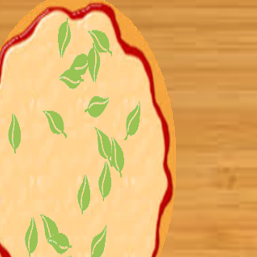

In [7]:


#Test to display an image
im = Image.open(real_train_data+'/images/'+os.listdir(real_train_data+'/images')[5]) 
# This method will show image in any image viewer 
im


# Getting the images and loading them.

In [8]:

#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_real_ds = ImageFolder(real_train_data, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

real_train_dl = DataLoader(train_real_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)


In [9]:
print(len(train_real_ds))
print(len(train_real_ds[0]))
print(len(train_real_ds[0][0]))
print(len(train_real_ds[0][0][0]))
print(len(train_real_ds[0][0][0][0]))
print(train_real_ds[0][0][0][0])


13321
2
3
256
256
tensor([-0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588,
        -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588,
        -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588,
        -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588,
        -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588,
        -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588, -0.0588,  0.0980,
         0.7412,  0.6549,  0.6549,  0.6549,  0.6549,  0.6627,  0.6627,  0.6627,
         0.6627,  0.6627,  0.6627,  0.6627,  0.6627,  0.6784,  0.6157,  0.0980,
        -0.1843,  0.6392,  0.8431,  0.7725,  0.7804,  0.7882,  0.7882,  0.7882,
         0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,
         0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,
         0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,  0.7882,
         0.7882,  0.78

# Basic functions to display images

In [10]:
%matplotlib inline

def denorm(img_tensors):
    return img_tensors
def show_images(images, nmax=64):
    print(images.shape)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
#show_batch(real_train_dl)

# Check for gpu and load data

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
real_train_dl = DeviceDataLoader(real_train_dl, device)


# Discriminator

In [12]:
# Discriminator architecture from J. Johnson, A. Alahi, and L. Fei-Fei, “Perceptual losses for real-time style transfer and super-resolution,” in ECCV, 2016.
# C64 − C128 − C256 − C512

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # C64 − C128 − C256 − C512

        self.c64 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.c128 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)

        )
        self.c256 = nn.Sequential(
            nn.Conv2d(128, 256,kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.c512 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        
        # single output 
        self.single_cov = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    
    def forward(self, x):
        x = self.c64(x)
        x = self.c128(x)
        x = self.c256(x)
        x = self.c512(x)
        x=self.single_cov(x)
        return x
        

In [13]:
discriminator = to_device(Discriminator(), device)

# Generator

In [15]:
class Reisdual(nn.Module):
    
    def __init__(self, input):
        super(Reisdual, self).__init__()
        kernel =3
        stride=1
        relflection_padding = (kernel-1)//2
        padding=0

        self.conv1 = nn.Sequential(
            nn.ReflectionPad2d(padding=relflection_padding),
            nn.Conv2d(input, input, kernel_size=kernel, stride=stride, padding=padding),
            nn.Dropout2d(0.2),
            nn.InstanceNorm2d(input, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ReflectionPad2d(padding=relflection_padding),
            nn.Conv2d(input, input, kernel_size=kernel, stride=stride, padding=padding),
            nn.Dropout2d(0.2),
            nn.InstanceNorm2d(input, affine=False, track_running_stats=False),
        )        

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)        
        return x + residual

In [16]:


# genarator architecture from J. Johnson, A. Alahi, and L. Fei-Fei, “Perceptual losses for real-time style transfer and super-resolution,” in ECCV, 2016.
# c7s1 − 64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.c7s1_64 = self.c7s1_k_64(3, 64, 7, 1)
        self.d128 = self.d_k(64, 128, 3, 2)
        self.d256 = self.d_k(128, 256, 3, 2)
        self.R256 = self.residual_block(256)
        self.u128 = self.u_k(256, 128, 3, 2)
        self.u64 = self.u_k(128, 64, 3, 2)
        self.c7s1_3 = self.c7s1_k_3(64, 3, 7, 1)
                 
    
    # c7s1 − 64
    def c7s1_k_64(self, input, output, kernel, stride):
        reflection_padding = (kernel - 1) // 2
        padding=0
        module = nn.Sequential(
            nn.ReflectionPad2d(padding=reflection_padding),
            nn.Conv2d(input, output, kernel_size=kernel,
                      stride=stride, padding=padding),
            nn.InstanceNorm2d(output, affine=False, track_running_stats=False),
            nn.ReLU(inplace=True)
        )

        return module

    #c7s1_3
    def c7s1_k_3(self, input, output, kernel, stride):
        reflection_padding = (kernel - 1) // 2
        padding=0
        return nn.Sequential(
            nn.ReflectionPad2d(padding=reflection_padding),
            nn.Conv2d(input, output, kernel_size=kernel,
                      stride=stride, padding=padding, bias=False),
        )

    # D128,D256
    def d_k(self, input, output, kernel, stride):
        padding=(kernel - 1) // 2
        # no reflection padding
        module = nn.Sequential(
            nn.Conv2d(input, output, kernel_size=kernel,
                      stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(output, affine=True),
            nn.ReLU(True)
        )
        return module
    
    # R256 Residual block defined above
    def residual_block(self, input):
        return Reisdual(input)

    
    # u128,u256
    def u_k(self, input, output, kernel, stride):
        module = nn.Sequential(
            nn.ConvTranspose2d(input, output, kernel_size=kernel,
                               stride=stride, padding=1, output_padding=1),
            nn.InstanceNorm2d(output, affine=False),
            nn.ReLU(inplace=True)
        )
        return module

    def forward(self, x):

        x = self.c7s1_64(x)
        x = self.d128(x)
        x = self.d256(x)

        # 9 times residual block
        for i in range(9):
            x = self.R256(x)


        # u128
        x = self.u128(x)
        # u64
        x = self.u64(x)
        # c7s1
        x = self.c7s1_3(x)
        return x


In [17]:
generator = Generator()
generator = to_device(generator, device)

torch.Size([10, 3, 256, 256])


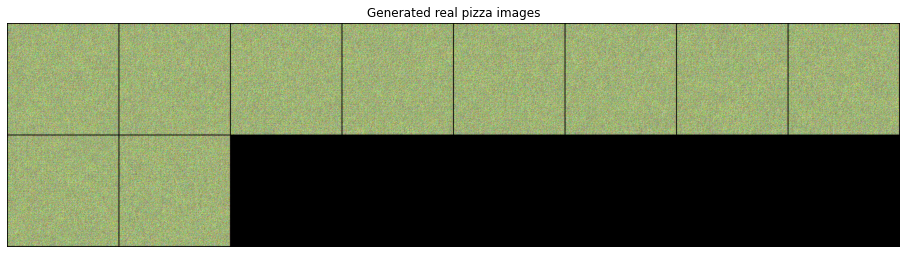

In [19]:
# test generator
# first create a generator

# then test it
# generate a random noise
z = torch.randn(batch_size, 3, 256, 256)
z=z.to(device)
# generate a fake image
fake_image = generator(z)
print(fake_image.shape)
img_grid = vutils.make_grid(fake_image, padding=2, normalize=True, nrow=8).cpu()
# show the fake image

fig=plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Generated real pizza images")
plt.imshow(np.transpose(img_grid, (1, 2, 0)))
fig.savefig('test_12_syn.png')

# print(img_grid.shape)
#show_images(fake_image)



# intialise weights

In [20]:
def init_weights(module):
    assert isinstance(module, nn.Module)
    if hasattr(module, "weight") and module.weight is not None:
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    if hasattr(module, "bias") and module.bias is not None:
        torch.nn.init.constant_(module.bias, 0.0)
    for c in module.children():
        init_weights(c)

init_weights(generator) 
init_weights(discriminator)       

# Discriminator Training

In [21]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    #print('Real')
    real_preds = discriminator(real_images)
    real_targets = torch.ones_like(real_preds,device=device)

    # print(real_preds.size(),real_targets.size())
    real_loss = criterion(real_preds, real_targets)
    with torch.no_grad():
        real_score = mean_loss(real_preds).mean().item()
    
    real_loss.backward()
    
    
    # Generate fake images
    sample=torch.randn(batch_size, 3, 256, 256, device=device)
    sample=sample.to(device)
    fake_images = generator(sample)

    # Pass fake images through discriminator
    #print('fake')
    fake_preds = discriminator(fake_images.detach())
    fake_targets = torch.zeros_like(fake_preds,device=device)

    fake_loss = criterion(fake_preds, fake_targets)
    with torch.no_grad():
        fake_score = mean_loss(fake_preds).mean().item()
    #
    fake_loss.backward()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
#     loss.backward()
    opt_d.step()
    return loss.item(), real_score,fake_score

# Generator Training

In [22]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    sample=torch.randn(batch_size, 3, 256, 256, device=device)
    sample=sample.to(device)
    fake_images = generator(sample)
    
    # Try to fool the discriminator
    #print('generator')
    preds = discriminator(fake_images)
    targets = torch.ones_like(preds, device=device)
    loss = criterion(preds, targets)
    with torch.no_grad():
        fake_score_gen = mean_loss(preds).mean().item()

    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item(),fake_score_gen

# Save generated images

In [23]:
# save sample images 

def save_samples(epoch=1):
    # Generate fake images
    sample=torch.randn(batch_size, 3, 256, 256, device=device)
    sample=sample.to(device)
    fake_images = generator(sample).cpu().detach()
    img_grid = vutils.make_grid(fake_images, padding=2, normalize=True, nrow=8).cpu()

    fig=plt.figure(figsize=(16, 16))
    plt.axis("off")
    plt.title(f"Generated image of {epoch}")
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))
    fig.savefig(f'{samples_dir}genrated_{epoch}.png')


# Training loop

In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    fake_scores_g =[]

    loss_g=0
    loss_d=0
    real_score=0
    fake_score=0
    fake_score_g=0
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    batches = len(real_train_dl)
    
    discriminator.train()
    generator.train()
    
    for epoch in range(epochs):
        # for real_images, _ in tqdm(real_train_dl):
        for index, (real_images, _) in enumerate(real_train_dl):
            #print(len(real_images))
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g,fake_score_g = train_generator(opt_g)


            iters = index + epoch * batches + 1
            writer.add_scalar("Train_Adversarial/D_Loss", loss_d, iters)
            writer.add_scalar("Train_Adversarial/G_Loss", loss_g, iters)
            writer.add_scalar("Train_Adversarial/D_Real", real_score, iters)
            writer.add_scalar("Train_Adversarial/D_Fake_Discriminator", fake_score, iters)
            writer.add_scalar("Train_Adversarial/D_Fake_Genrator", fake_score_g, iters)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        fake_scores_g.append(fake_score_g)


        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated imagess
        save_samples(epoch)
        # save model
        torch.save(discriminator.state_dict(), os.path.join(models_dir, f"discr_{epoch}.pth"))
        torch.save(generator.state_dict(), os.path.join(models_dir, f"genr_{epoch}.pth"))

    
    return losses_g, losses_d, real_scores, fake_scores,fake_scores_g

In [ ]:
history = fit(epochs, lr)

In [26]:
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |